In [105]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib as mpl
import pickle

In [106]:
# Load Landlab components
sys.path.append(r'./DrylandsHillslopeLEM/funcs')
from funcs.OverlandFlow_YS import OverlandFlow
from landlab.components import SoilInfiltrationGreenAmpt
from funcs.Cliff import Cliff
from funcs.priority_flood_flow_router.priority_flood_flow_router import PriorityFloodFlowRouter
from funcs.SizeDependentClastTransport import SizeDependentClastTransport
from funcs.TimeStepCalculator import TimeStepCalculator
from funcs.GradMapper import GradMapper
from funcs.ClastGrading import ClastGrading
from landlab.components import LinearDiffuser
from funcs.DepthSlopeProduct_YS import DepthSlopeProductErosion

In [107]:
# Load the example grid with 'topographic__elevation' and 'lithological_contact_height' fields
with open(r'./grid_data/grid_example.pkl', 'rb') as f:
    grid = pickle.load(f)

grid.fields()

{'at_node:lithological_contact_height', 'at_node:topographic__elevation'}

In [108]:
## Debris grading parameters
maxsize  = 2                      # The maximal grainsize in the distribution [m] 
n_size_classes = 30               # Number of size classes [-] 
clasts_n = 1500                   # Initial number of particles in the debris layer [-] 
name = 'p2-0-100'                 # Grading style/pattern  [-] 
initial_median_grainsize = 0.011  # The median grain size at the begining of the simulation [m] 
CGS = 0.05                        # The median grain size for cliff-derived debris [m] 

# Create grading scheme
grading = ClastGrading(
    grid,
    grading_name = name,
    n_size_classes = n_size_classes)
grading.set_grading_classes(maxsize = maxsize)
grading.create_transion_mat()

# Create grain size distribution for initial debris layer
grading.create_dist(
    median_size = initial_median_grainsize,
    num_of_clasts = clasts_n,
    init_val_flag = True)

# Create grain size distribution for cliff debris
grading.create_dist(median_size = CGS,
                    init_val_flag = False) # Saved as "g_state_slide"
grid.g1 = grading # save it.

# Soil depth field is created by grading component
soil = grid.at_node['soil__depth']

# Update topography and add bedrock field after soil field is added:
topo = grid.at_node['topographic__elevation']
bedrock = grid.add_zeros('bedrock__elevation', at="node")
bedrock[:] = topo[:]
topo[:]  = bedrock[:] + soil[:]

In [109]:
# Parameter for Cliff component
D_coef = 0.03                # Debris Diffusivity [m2/storm] 
cliff_br_ks = 10 ** -10      # Hydraulic conductivity for caprock (bedrock) [m/s]
sediment_ks = 10 ** -6       # Hydraulic conductivity for debris layer [m/s]
lower_layer_ks = 10 ** -6.5  # Hydraulic conductivity for lower-layer bedrock [m/s]
threshold_slope = 33         # Threshold slope for cliff-debris [deg]
critical_soil_depth = 0.5    # Decay/threshold depth [m]
critical_height_failure = 5  # Critical height for cliff undermining [m]
clast_density  = 2000        # Debris clasts density  [kg/m3]
weathering_rate = 0.01       # Weathering rate per storm [m/storm]
cliff_br_ke = 10**-10,       # Cliff (caprock) bedrock erodibility [m^2 s^2 /kg]
lower_layer_ke = 5*10 ** -5  # Lower layer (softer) bedrock erodibility [m^2 s^2 /kg]

CS = Cliff(grid,
        weathering_rate = weathering_rate,
        cliff_br_ks = cliff_br_ks,
        sediment_ks = sediment_ks,
        lower_layer_ks = lower_layer_ks,
        cliff_br_ke = cliff_br_ke,
        lower_layer_ke = lower_layer_ke ,
        threshold_slope = threshold_slope,
        critical_soil_depth = critical_soil_depth,
        sediment_diffusivity = D_coef,
        critical_height = critical_height_failure,
        bedrocklandslide_grainsize_fractures = grid.g1.g_state_slide)

In [110]:
# Overland flow anrunoff-driven sediment transport 
roughness = 0.04   # Manning's roughness
grid.add_zeros('water_surface__slope',
               at="node")

ld = OverlandFlow(grid, mannings_n = roughness, steep_slopes=True)
st = SizeDependentClastTransport(grid)
gradmap = GradMapper(grid=grid)       # Gradient mapper for stability chekcs
DtCalc = TimeStepCalculator(grid=grid) # Calculator of stable time step between all model componenets

In [111]:
# Hillslope diffusion
tl_diff = LinearDiffuser(grid, linear_diffusivity='linear_diffusivity')

In [112]:
# Infiltration component
infilitration_depth = grid.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
infilitration_depth *= 0.03 ## meter
SI = SoilInfiltrationGreenAmpt(grid,hydraulic_conductivity=grid.at_node['hydraulic_conductivity'],
                                   soil_type='silty clay',
                                   initial_soil_moisture_content=0.05,
                                   volume_fraction_coarse_fragments =0.1,
                                   )

In [113]:
# Bedrock incision
k_e =  5*10**-5                          # Bedorck erodibility
g = 9.81                                 # Gravity coef
tau_crit = 1                             # Critical stress for bedrock incision                    
dspe = DepthSlopeProductErosion(
        grid,
        k_e = 'erodibility__coefficient',
        g = g,
        tau_crit = tau_crit,
        slope = 'water_surface__slope')

In [114]:
# FlowRouter component
fr = PriorityFloodFlowRouter(
        grid,
        flow_metric="D8",
        separate_hill_flow=True,
        hill_flow_metric="Quinn",
        update_hill_flow_instantaneous=True, depression_handler='fill'
    )
fr.run_one_step()

In [115]:
# Remove debris from initial caprock
g_state2D = np.reshape(grid.at_node['grain__weight'],(grid.shape[0], grid.shape[1], n_size_classes))
gw = grid.at_node['grain__weight']
CS.update_cliff_state()
soil[grid.at_node['cliff_nodes']==True] = 0
for col  in range(grid.number_of_node_columns):
    cliff_end = np.where(CS.cliff_base[:,col]==True)[0]
    if np.any(cliff_end) == True:
        g_state2D[cliff_end[0]:,:,:] = 0
topo[:] = soil[:] + bedrock[:]
grid.at_node['grain__weight'] = np.reshape(g_state2D, (grid.shape[0] * grid.shape[1], n_size_classes))
grading.update_sizes()

In [116]:
# Create rainstorms input
n_of_storm_to_simulate = 100
base_rainfall_rate = np.ones(30)
base_rainfall_rate[0:10] *= 38
base_rainfall_rate[10:20] *= 88
base_rainfall_rate[20:30] *= 18
rainfall_rate = base_rainfall_rate*(0.001 / 3600.0) # mm/h to m/s
rainfall_intensties = np.tile(rainfall_rate.transpose(), (n_of_storm_to_simulate, 1))
rainfall_durations = np.ones_like(rainfall_intensties)*60

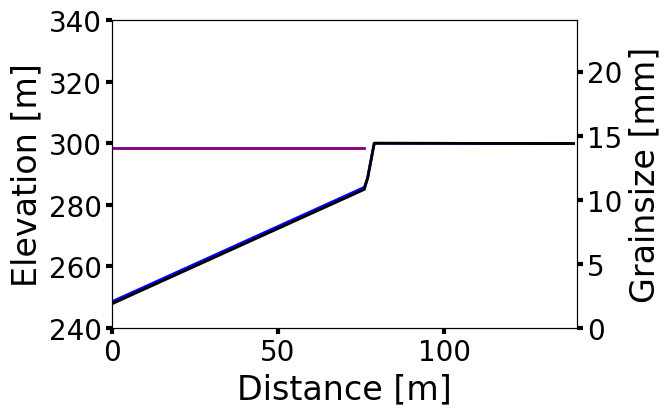

In [117]:
# Create a plotting function for later
def plot_topography(grid):
    topo_p = grid.node_vector_to_raster(grid.at_node['topographic__elevation'])[:, 1]
    bedrock_p = grid.node_vector_to_raster(grid.at_node['bedrock__elevation'])[:, 1]
    ms = grid.node_vector_to_raster(grid.at_node['median__size_weight'])[:,1] * 1000 # in mm
    soil_p = grid.node_vector_to_raster(soil)[:,1]
    ms[soil_p<0.1] = np.nan
    
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    ax.plot(topo_p , lw = 2, color = 'blue'),
    ax.plot(bedrock_p , color='k', lw = 2),
    ax.set_xlabel('Distance [m]', fontsize=24)
    ax.set_ylabel('Elevation [m]', fontsize=24)
    ax.set_ylim([240,340])
    ax.set_xlim([0,140])
    ax2 = ax.twinx()
    ax2.set_ylim([0,np.nanmax(ms)+10])
    ax2.set_ylabel('Grainsize [mm]', fontsize=24)
    ax2.plot(ms,color = 'purple', lw = 2)
    ax.tick_params(which = 'both',width=3, length=4, labelsize=20)
    ax2.tick_params(which = 'both',width=3, length=4, labelsize=20)
    plt.show()
    
# Ploting initial topography 
plot_topography(grid)

1


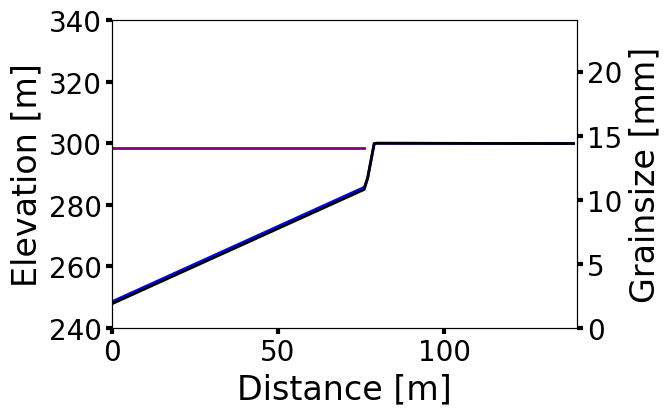

2
3
4


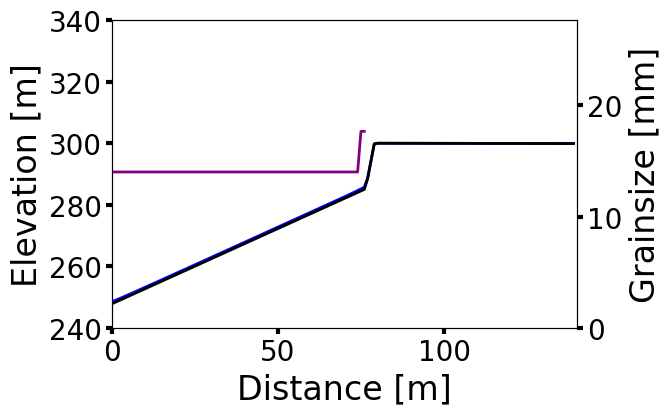

5
6
7


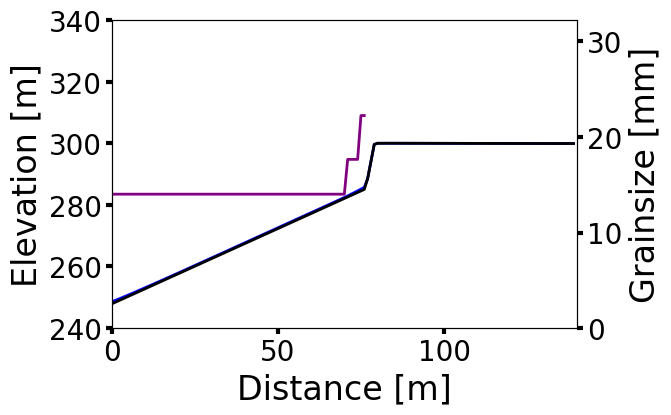

8
9
10


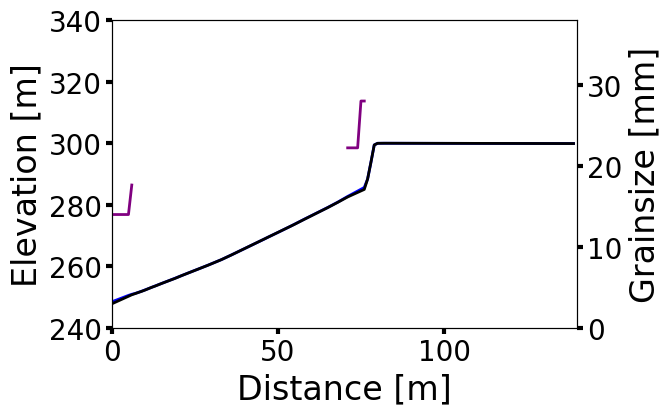

11
12
13


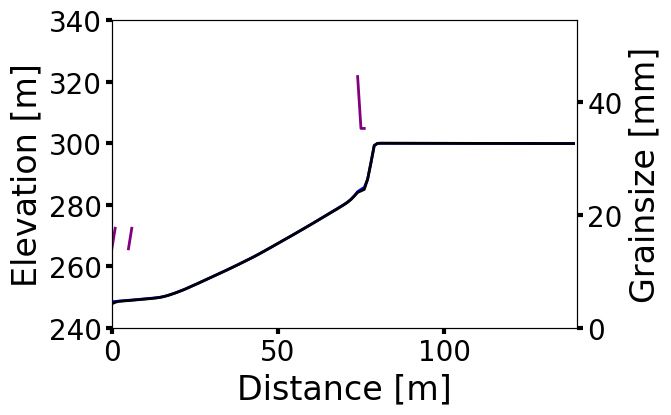

14
15
16


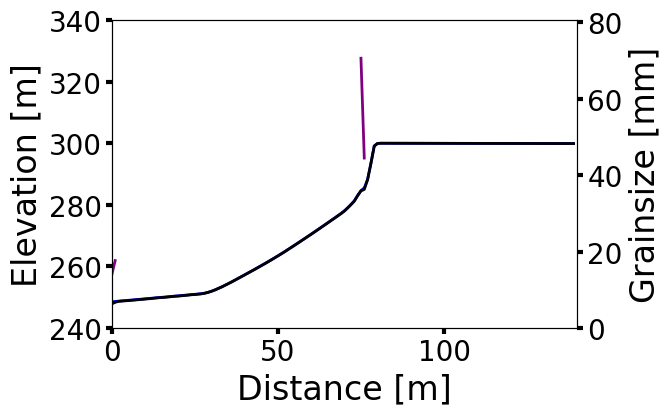

17
18
19


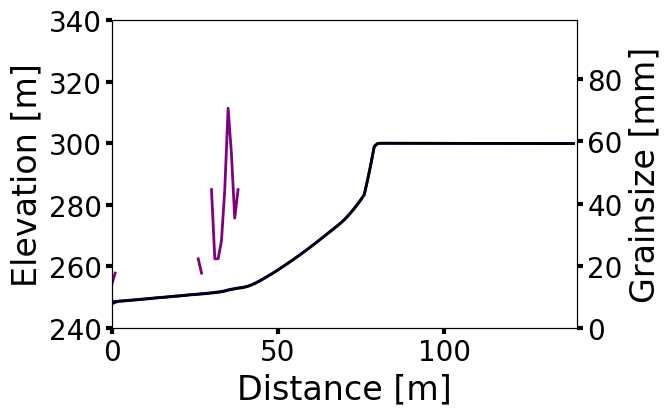

20
21
22


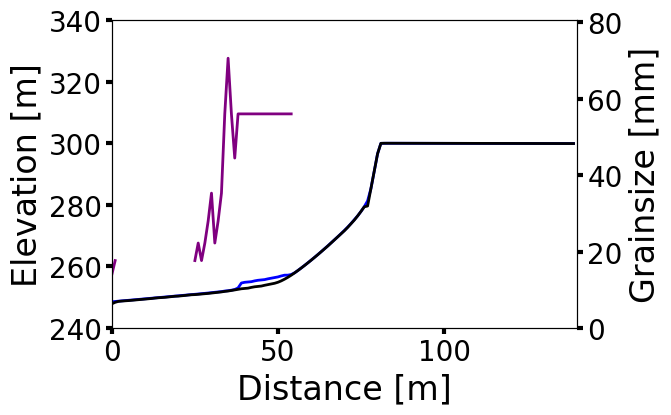

23
24
25


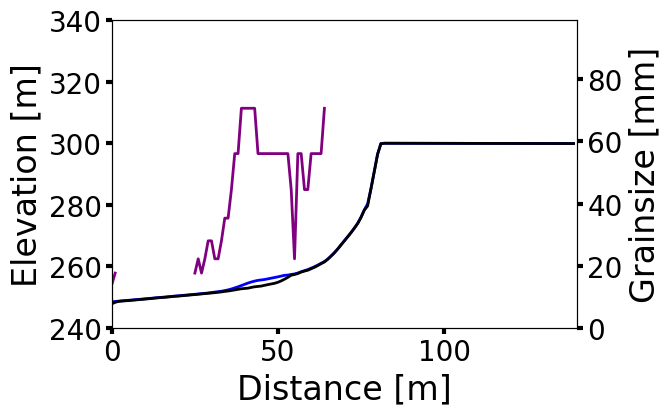

26
27
28


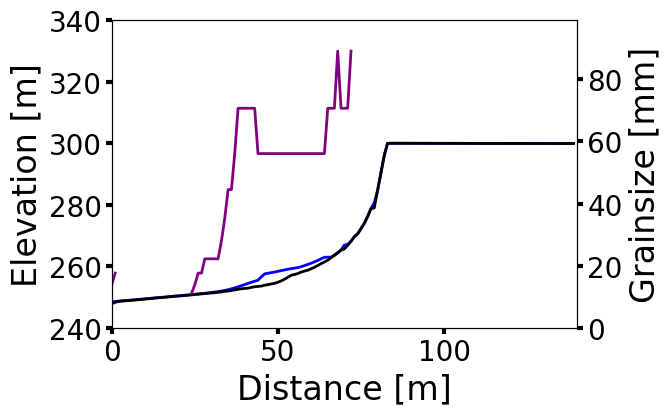

29
30
31


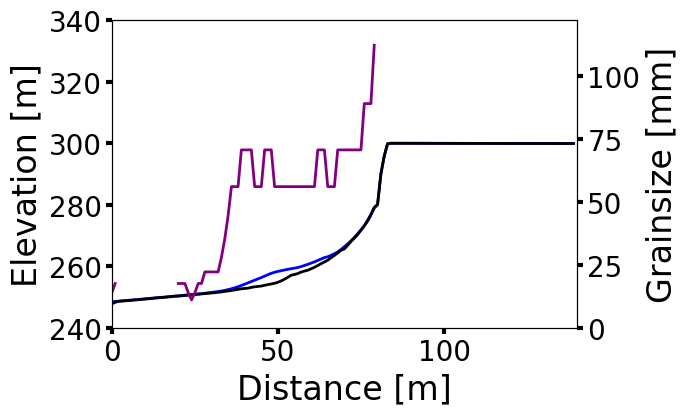

32
33
34


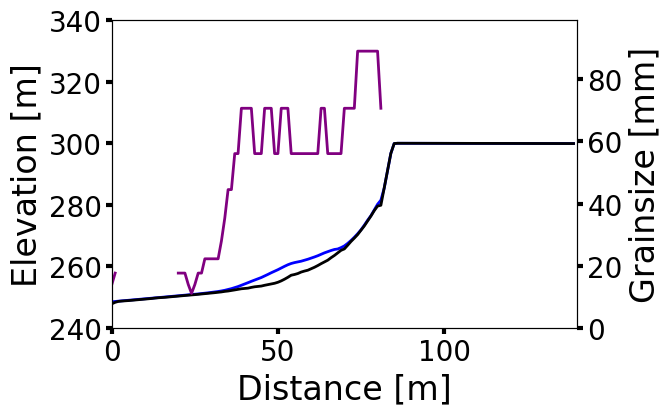

35
36
37


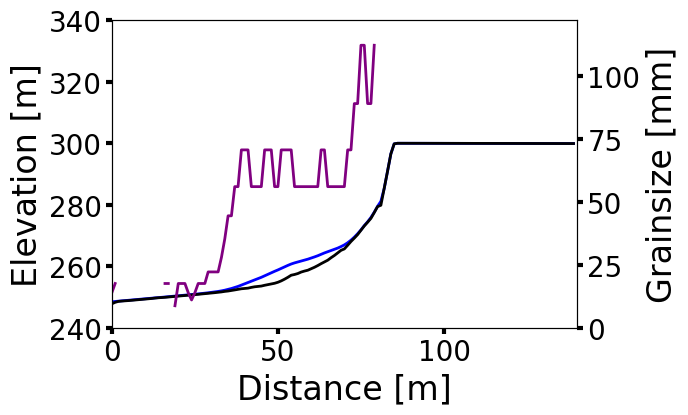

38
39
40


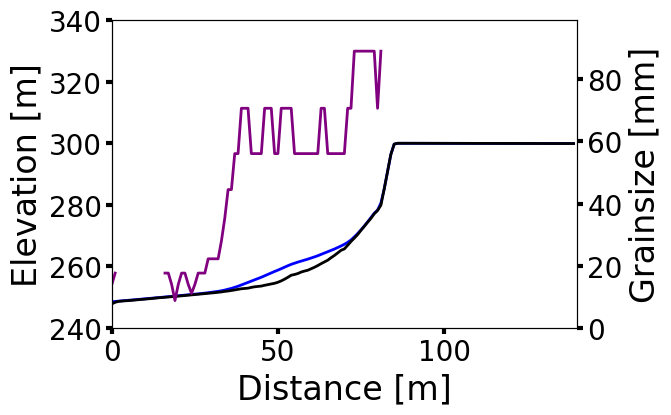

41
42
43


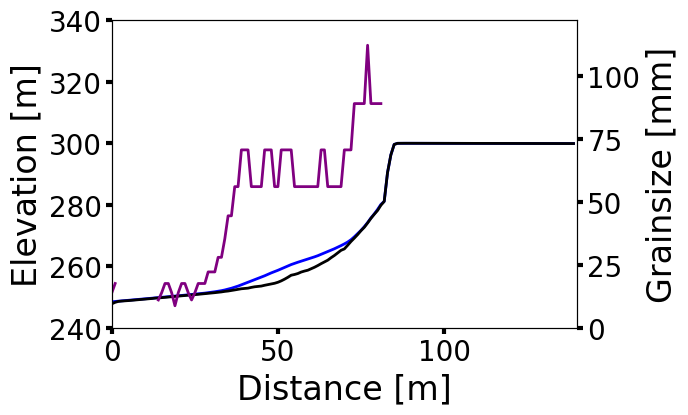

44
45
46


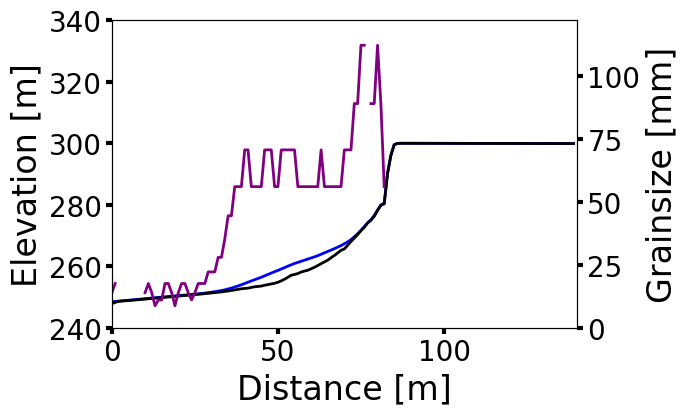

47
48
49


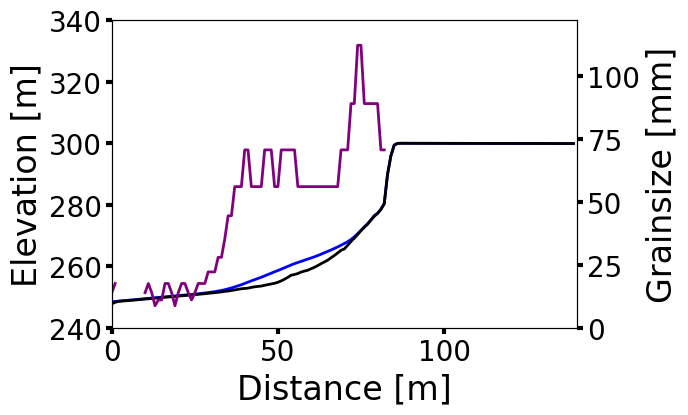

50
51
52


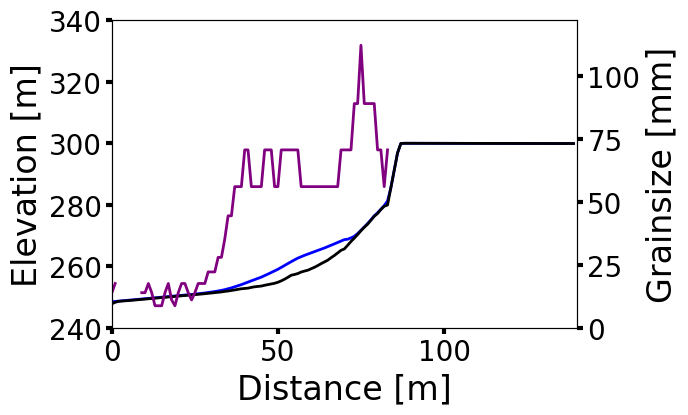

53
54
55


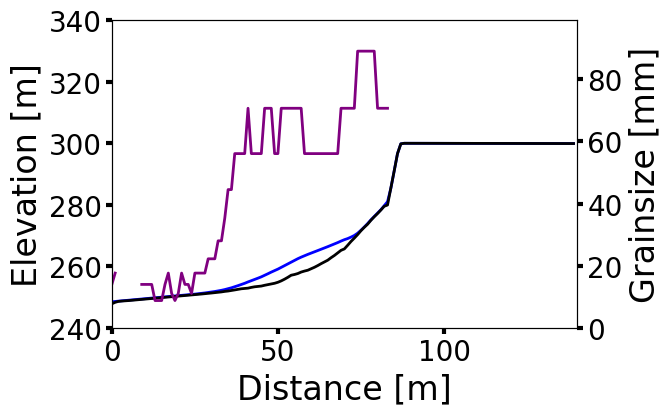

56
57
58


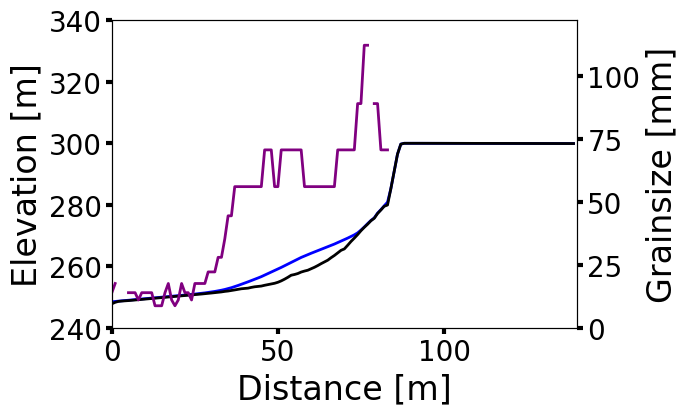

59
60
61


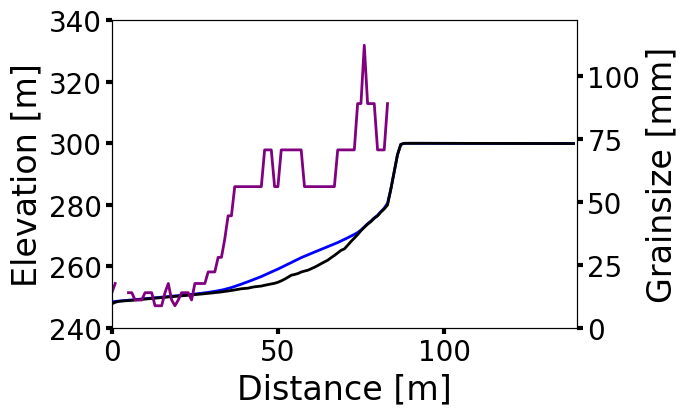

62
63
64


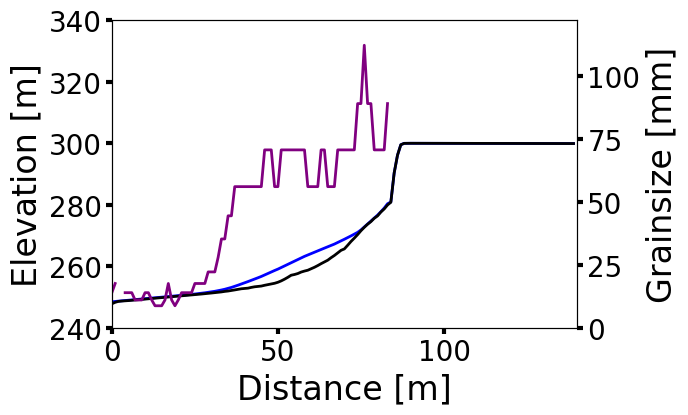

65
66
67


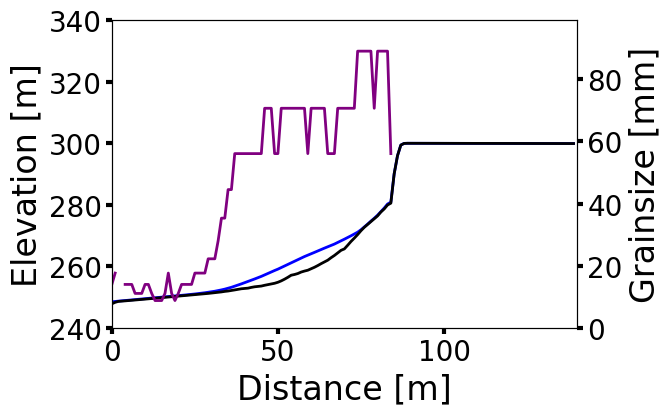

68
69
70


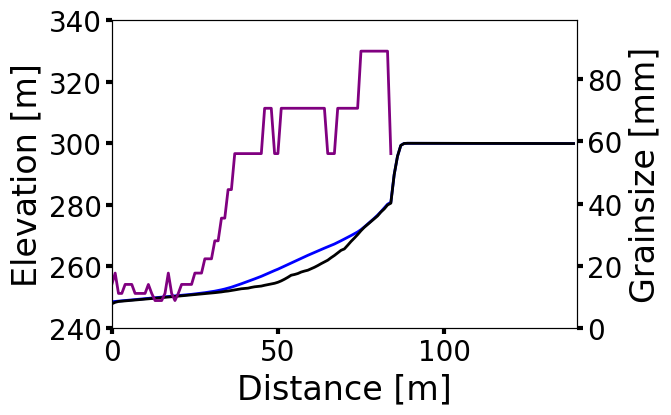

71
72
73


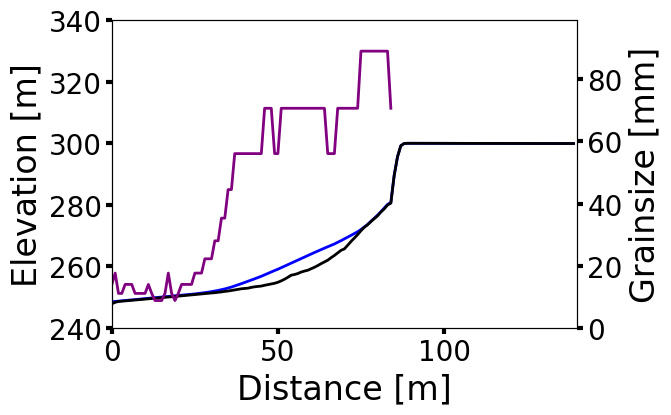

74
75
76


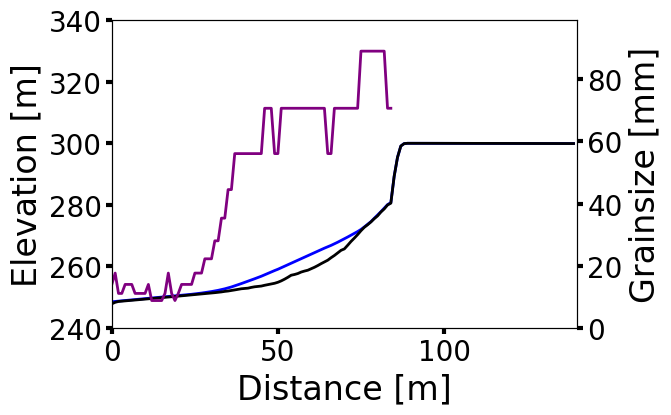

77
78
79


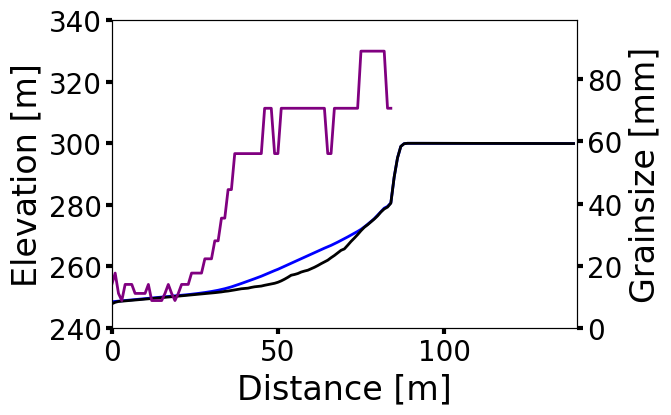

80
81
82


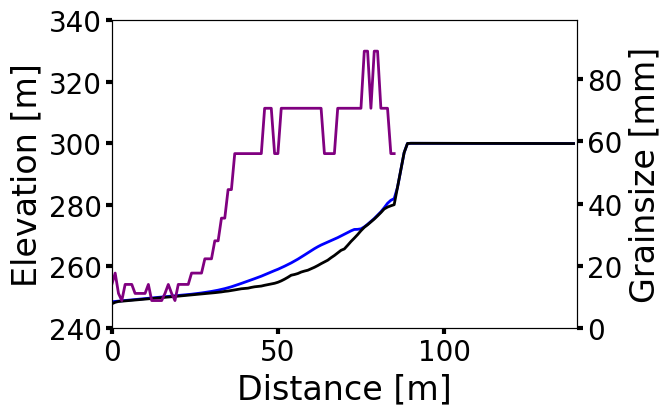

83
84
85


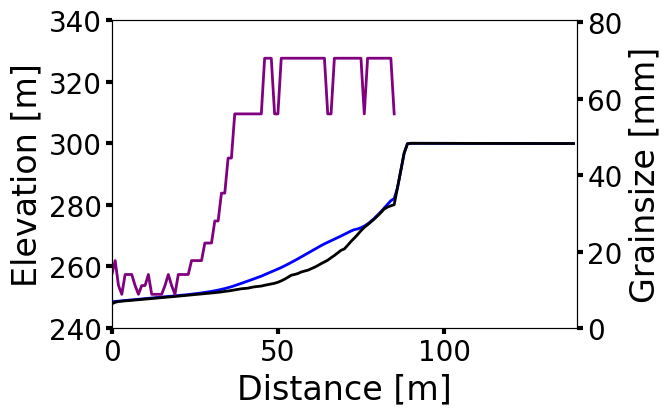

86
87
88


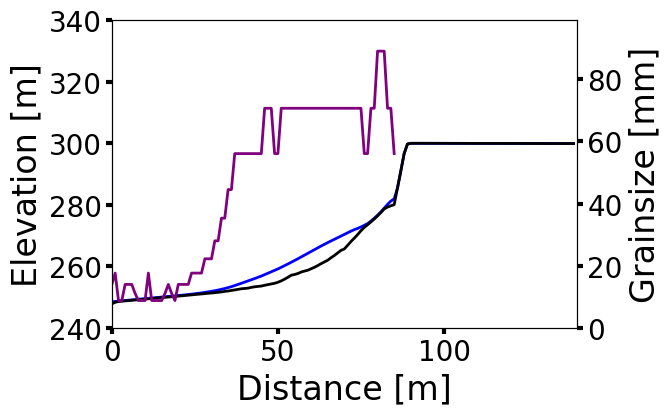

89
90
91


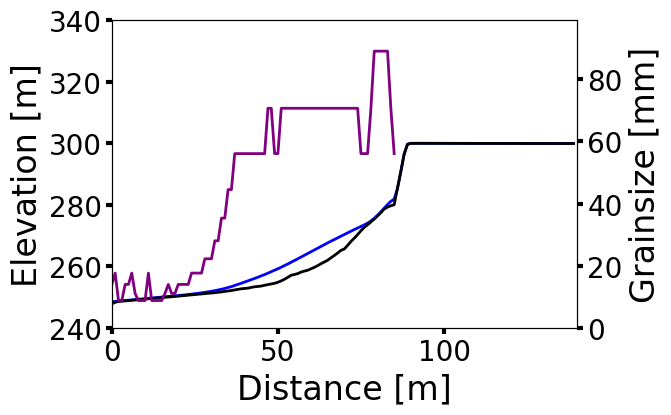

92
93
94


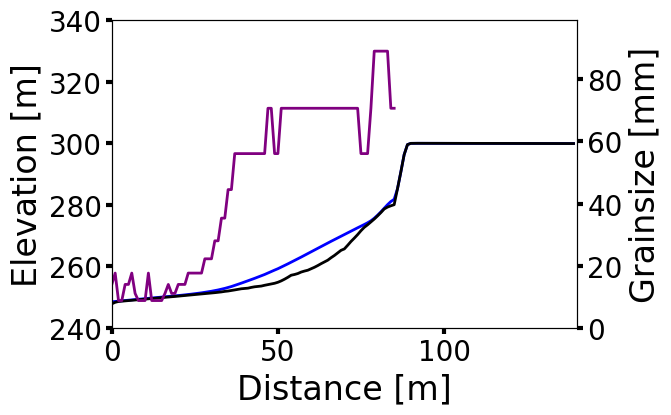

95
96
97


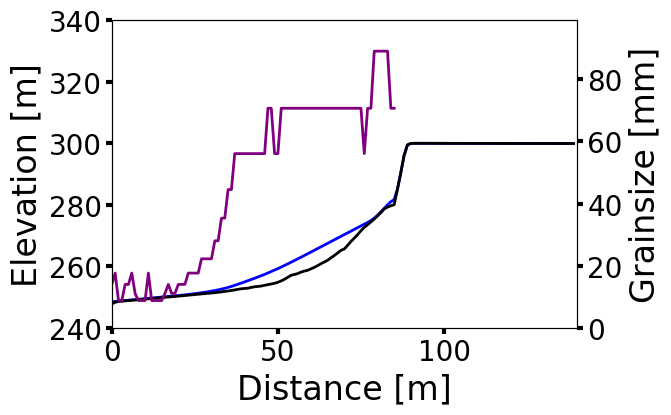

98
99
100


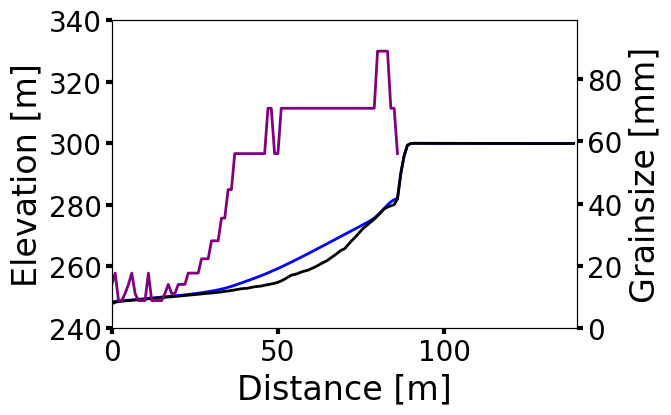

In [118]:
## Main ##

# Pointers
bedrock = grid.at_node['bedrock__elevation']
topo = grid.at_node['topographic__elevation']
soil  = grid.at_node['soil__depth']

# Simulation parameters
dt = 20 #Max dt
cnt=0
grid_size = np.size(grid.core_nodes)
epsilon = 1.0e-10
epsilon_2 = 0.0001 # Waterdepth threshold for 
# Do: iterate over all storms
for storm_cnt in range(1, n_of_storm_to_simulate + 1):

    print(storm_cnt)
    rainfall_rate = rainfall_intensties[storm_cnt - 1, :]  # minute time steps.
    rainfall_duration = np.cumsum(rainfall_durations[storm_cnt - 1, :])  # minute time steps.
    rain_duration = (np.size(rainfall_rate) * 60)  # total rain durtaion inn sec
    nsteps = int(rain_duration / dt)
    infilitration_depth[:] = SI._min_water
    int_index = 0
    min_cnt = 60
    current_rainfall_duration = rainfall_duration[int_index]
    elapse_dts = 0

    fr.run_one_step()
    topo_before_diff = topo.copy()
    tl_diff.run_one_step(dt=1)
    topo[:] = topo_before_diff[:]
    CS.update_diffusive_mass(flux=grid.at_link['hillslope_sediment__unit_volume_flux'])
    topo[:] = soil[:] + bedrock[:]
    grading.update_sizes()
    fr.run_one_step()
    CS.weathering_run_one_step()
    CS.sediment_run_out()
    CS.update_mass()
    grading.update_sizes()
    
    grading.run_one_step(A_factor = 0.0001)
    if storm_cnt>cnt:
        plot_topography(grid)
        cnt+=3

    print_time = 0
    cnt_intra = 0

    while elapse_dts < rainfall_duration[-1]:

        if elapse_dts >= current_rainfall_duration:  # sec
            int_index += 1
            grading.update_sizes()
            CS.update_cliff_state()
            current_rainfall_rate = rainfall_rate[int_index]
            current_rainfall_duration = rainfall_duration[int_index]
            ld.rainfall_intensity = current_rainfall_rate  # meter per sec -> For the OverlandFlow component

        gradmap.run_one_step()
        st.calc_dt()
        ld.calc_time_step()
        dspe.calc_E()
        dt_stable = DtCalc.calc_dt(dt_sediment = st._dt,
                                   dt_flow = ld._dt,
                                   dt_bedrock_incision=dspe._stable_dt)            # dt in sec

        dt_to_run = np.min((dt_stable, current_rainfall_duration - elapse_dts, dt))
        if (ld._dt == dt_to_run):
            dt_to_run = np.min((st._dt, dspe._stable_dt, dt))
            dspe.run_one_step(dt=dt_to_run)
            st.run_one_step(dt=dt_to_run)
            SI.run_one_step(dt=dt_to_run)
            sec_counter = 0
            while sec_counter<dt_to_run:
                dt_to_run_of = np.min((ld._dt, dt_to_run - sec_counter))
                ld.run_one_step(dt=dt_to_run_of)
                sec_counter +=  dt_to_run_of
                ld.calc_time_step()
        else:
            dspe.run_one_step(dt=dt_to_run)
            st.run_one_step(dt=dt_to_run)
            SI.run_one_step(dt=dt_to_run)
            ld.run_one_step(dt=dt_to_run)

        elapse_dts += dt_to_run
    while np.max(grid.at_node['surface_water__depth']) >= 0.0001: 
        gradmap.run_one_step()
        ld.rainfall_intensity = epsilon
        st.calc_dt()
        ld.calc_time_step()
        dspe.calc_E()
        dt_stable = DtCalc.calc_dt(dt_sediment = st._dt,
                                   dt_flow = ld._dt,
                                   dt_bedrock_incision=dspe._stable_dt)           
        dt_to_run = np.min((dt_stable, dt))
        if (ld._dt == dt_to_run):
            dt_to_run = np.min((st._dt, dspe._stable_dt, dt))
            dspe.run_one_step(dt=dt_to_run)
            st.run_one_step(dt=dt_to_run)
            SI.run_one_step(dt=dt_to_run)
            sec_counter = 0
            while sec_counter < dt_to_run:
                dt_to_run_of = np.min((ld._dt, dt_to_run - sec_counter))
                ld.run_one_step(dt=dt_to_run_of)
                sec_counter += dt_to_run_of
                ld.calc_time_step()
        else:
            dspe.run_one_step(dt=dt_to_run)
            st.run_one_step(dt=dt_to_run)
            SI.run_one_step(dt=dt_to_run)
            ld.run_one_step(dt=dt_to_run)
    
    fr.run_one_step()
    CS.failure_run_one_step()
    fr.run_one_step()
    CS.sediment_run_out()
    CS.update_mass()
    grading.update_sizes()




fig, ax = plt.subplots(1,4, figsize= (20,5))
ax[0].plot(topo_2D[:,13]),
ax[1].plot(topo_2D[5,:]),
ax[2].plot(soil_2D[5,:]), 
ax[3].plot(d50_2D[5,:]), plt.show()



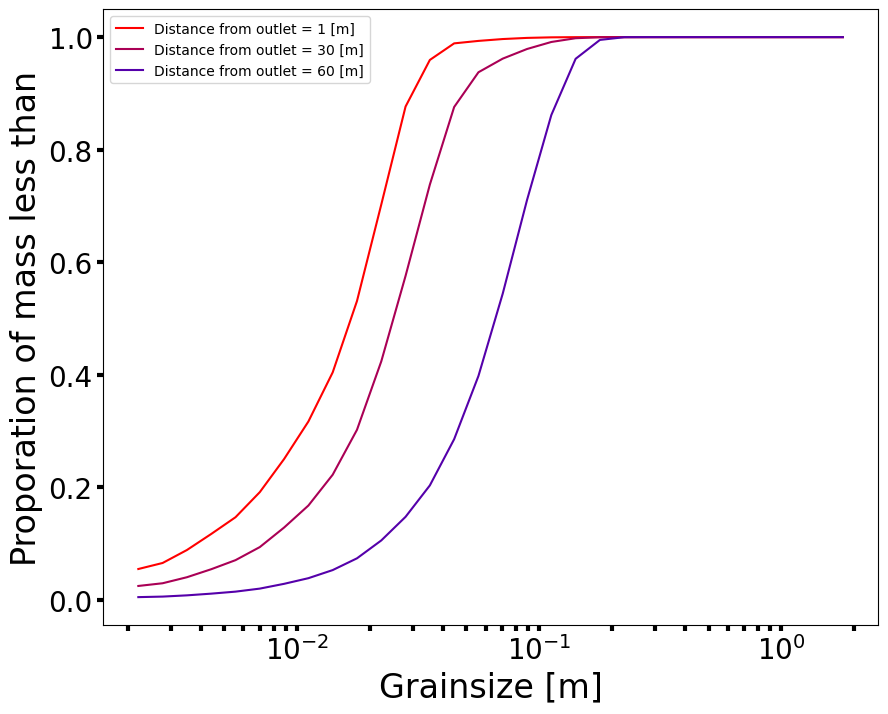

In [119]:
## Plot grainsize distribution for diffrent locations along the profile
rows = np.array((1,30,60))
nodes = (rows*3)+1
def colorFader(c1,c2,mix=0):
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='red'   
c2='blue' 
colors = []
fig, ax = plt.subplots(1,1, figsize=(10,8))
for n in range(np.size(nodes)):
    colors.append(colorFader(c1,c2,n/np.size(nodes)))
                                             
for node,row,color in zip(nodes,rows,colors):
    ax.plot(grid.g1.meansizes,np.cumsum(grid.at_node['grain__weight'][node ,:]) / np.sum(grid.at_node['grain__weight'][node ,:]),
             color= color, label = 'Distance from outlet = ' + str(row) +' [m]')
ax.set_xscale('log')
ax.set_xlabel('Grainsize [m]', fontsize=24)
ax.set_ylabel('Proporation of mass less than', fontsize=24)
ax.tick_params(which = 'both',width=3, length=4, labelsize=20)
ax.legend()